# Explore here

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df= pd.read_csv(r"https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv").iloc[:,1:]
pd.set_option('display.max_columns', None)
df

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [39]:
df.shape

(48895, 15)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

In [41]:
df.nunique()

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [42]:
df.drop(['room_type', 'calculated_host_listings_count'], axis=1, inplace=True)

In [43]:
df.duplicated().sum()

0

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [45]:
df1 = df[['neighbourhood_group', 'price']]
df1

,neighbourhood_group,price
0,Brooklyn,149
1,Manhattan,225
2,Manhattan,150
3,Brooklyn,89
4,Manhattan,80
...,...,...
48890,Brooklyn,70
48891,Brooklyn,40
48892,Manhattan,115
48893,Manhattan,55


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


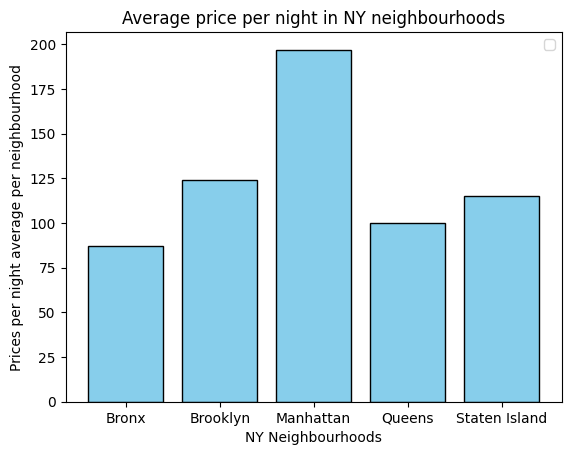

In [46]:
#Medias de los precios por noche de cada vecindario
import matplotlib.pyplot as plt

price_bronx = df1.loc[df['neighbourhood_group']== 'Bronx', 'price'].mean().round()
price_brooklyn = df1.loc[df['neighbourhood_group']== 'Brooklyn', 'price'].mean().round()
price_manhattan = df1.loc[df['neighbourhood_group']== 'Manhattan', 'price'].mean().round()
price_queens = df1.loc[df['neighbourhood_group']== 'Queens', 'price'].mean().round()
price_statenisland = df1.loc[df['neighbourhood_group']== 'Staten Island', 'price'].mean().round()

#Valores adicionales a mostrar en el plot
x = [0,1,2,3,4]
xlabels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
xvalues = [price_bronx, price_brooklyn, price_manhattan, price_queens, price_statenisland]
plt_lenght = np.arange(len(x))

plt.bar(plt_lenght, xvalues, color='skyblue', edgecolor='black', align='center')
plt.xlabel('NY Neighbourhoods')
plt.ylabel('Prices per night average per neighbourhood')
plt.title('Average price per night in NY neighbourhoods')
plt.xticks(x, xlabels)
plt.legend()
plt.show()


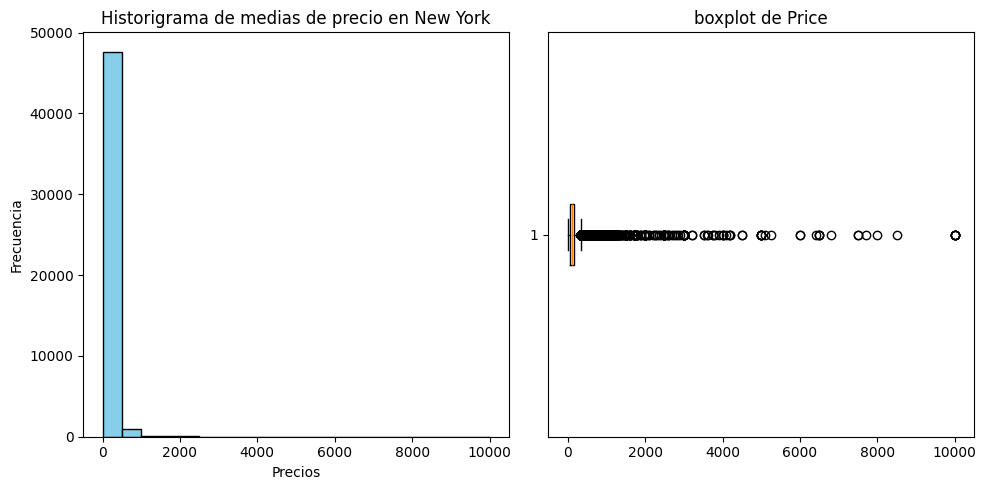

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Historigrama de medias de precio en New York')
ax[0].set_xlabel('Precios')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('boxplot de Price')
ax[1].set_label('Precio')

plt.tight_layout()
plt.show()

In [48]:
df['log_price'] = np.log(df.price+0.1)
df

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,log_price
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,2018-10-19,0.21,365,5.004617
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,355,5.416545
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,150,3,0,NaN,NaN,365,5.011302
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,194,4.489759
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,0,4.383276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,70,2,0,NaN,NaN,9,4.249923
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,40,4,0,NaN,NaN,36,3.691376
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,115,10,0,NaN,NaN,27,4.745801
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,55,1,0,NaN,NaN,2,4.009150


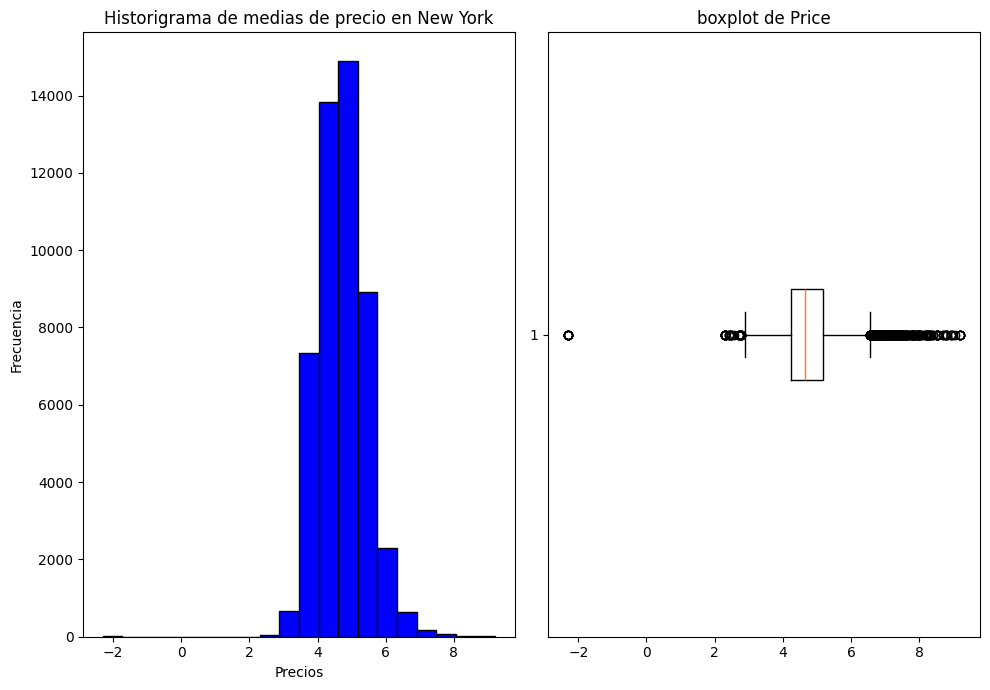

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,7))

ax[0].hist(df['log_price'], bins=20, color='blue', edgecolor='black')
ax[0].set_title('Historigrama de medias de precio en New York')
ax[0].set_xlabel('Precios')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(df['log_price'], vert=False)
ax[1].set_title('boxplot de Price')
ax[1].set_label('Precio')

plt.tight_layout()
plt.show()

In [50]:
df.isnull().mean()*100
#Que porcentaje de casillas tiene Nan datos

name                    0.032723
host_id                 0.000000
host_name               0.042949
neighbourhood_group     0.000000
neighbourhood           0.000000
latitude                0.000000
longitude               0.000000
price                   0.000000
minimum_nights          0.000000
number_of_reviews       0.000000
last_review            20.558339
reviews_per_month      20.558339
availability_365        0.000000
log_price               0.000000
dtype: float64

In [51]:
df.drop(['last_review', 'reviews_per_month'], axis=1, inplace=True) 
#Elimino las variables que mas Nans tienen, para limpiar m+as los datos

In [52]:
df.isnull().any(axis=1).sum()/len(df)*100
#Ahora obtengo un porcentaje general de Nans de todo el data set, al eliminar las variables com mayor participacion, mis datos son mas confiables

0.07567235913692606

<Axes: >

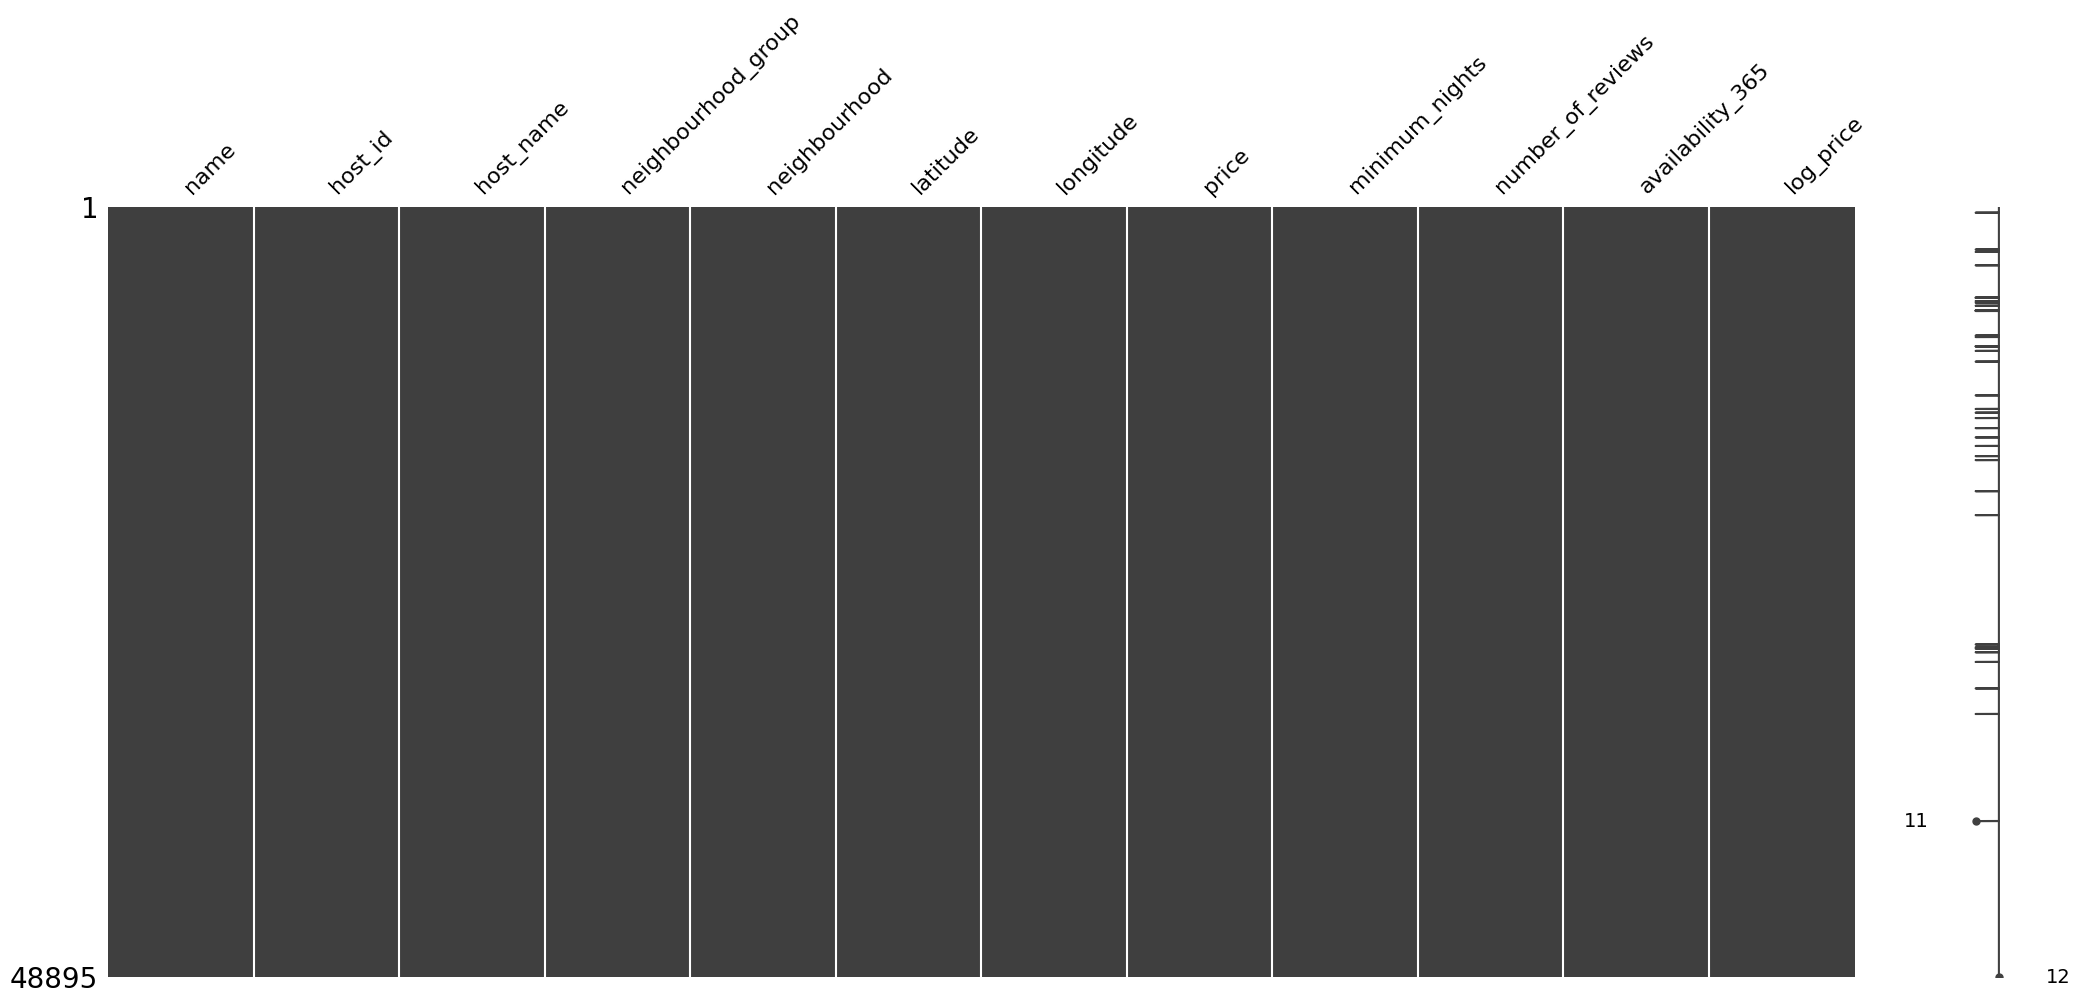

In [53]:
import missingno as msno

msno.matrix(df)
#Me muestra en que nive hay datos faltantes

In [54]:
df.isna().sum()
#ahora me muestra exactamente que variables tienen datos Nan

name                   16
host_id                 0
host_name              21
neighbourhood_group     0
neighbourhood           0
latitude                0
longitude               0
price                   0
minimum_nights          0
number_of_reviews       0
availability_365        0
log_price               0
dtype: int64

In [55]:
df.drop(['name', 'host_name'], inplace=True, axis=1)
df
#Solo con el host id puedo trackear cuentas individuales

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,log_price
0,2787,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,365,5.004617
1,2845,Manhattan,Midtown,40.75362,-73.98377,225,1,45,355,5.416545
2,4632,Manhattan,Harlem,40.80902,-73.94190,150,3,0,365,5.011302
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,194,4.489759
4,7192,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,0,4.383276
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,70,2,0,9,4.249923
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,40,4,0,36,3.691376
48892,23492952,Manhattan,Harlem,40.81475,-73.94867,115,10,0,27,4.745801
48893,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,55,1,0,2,4.009150


In [56]:
host_population = df[["host_id"]].groupby("host_id").value_counts()
host_population

#Esto me especifica que hay algunos anuncios de este Dataframe pertenecen al mismo anfitrion y cuantos.

host_id
2438         1
2571         1
2787         6
2845         2
2868         1
            ..
274273284    1
274298453    1
274307600    1
274311461    1
274321313    1
Name: count, Length: 37457, dtype: int64

In [57]:
#Asi sabemos que esta dataframe en realidad nos habla de la actividad de 37547 anfitriones

In [58]:
#Quiero quedarme unicamente con los Host que tienen mas de dos anuncios publicados
duplicated_rows= df[df['host_id'].duplicated()==True]
duplicated_rows

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,log_price
22,22486,Brooklyn,Park Slope,40.67989,-73.97798,80,1,39,364,4.383276
23,22486,Brooklyn,Park Slope,40.68001,-73.97865,110,2,71,304,4.701389
33,32294,Manhattan,Harlem,40.82130,-73.95318,50,3,273,359,3.914021
35,9744,Brooklyn,South Slope,40.66869,-73.98780,89,4,168,340,4.489759
39,7549,Manhattan,Lower East Side,40.71401,-73.98917,40,1,214,188,3.691376
...,...,...,...,...,...,...,...,...,...,...
48887,208514239,Brooklyn,Williamsburg,40.71232,-73.94220,170,1,0,365,5.136386
48889,107716952,Queens,Jamaica,40.69137,-73.80844,65,1,0,163,4.175925
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,70,2,0,9,4.249923
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,40,4,0,36,3.691376


In [59]:
#Quiero saber quien es el host con mas anuncios en cada una de las cinco zonas de ny y cuantos tiene

count = duplicated_rows[['host_id']].value_counts().nlargest(10)
count #me muestra cuales son los host con mas anuncios, pero necesito filtrar la informacion de acuerdo al barrio tambien       

host_id  
219517861    326
107434423    231
30283594     120
137358866    102
12243051      95
16098958      95
61391963      90
22541573      86
200380610     64
7503643       51
Name: count, dtype: int64

In [60]:
brooklyn_listings = duplicated_rows[duplicated_rows['neighbourhood_group']== 'Brooklyn']
bronx_listings = duplicated_rows[duplicated_rows['neighbourhood_group']== 'Bronx']
manhattan_listings = duplicated_rows[duplicated_rows['neighbourhood_group']== 'Manhattan']
queens_listings = duplicated_rows[duplicated_rows['neighbourhood_group']== 'Queens']
statenisland_listings = duplicated_rows[duplicated_rows['neighbourhood_group']== 'Staten Island']

#Separo y filtro por cada barrio

In [61]:
brooklyn_main_host = brooklyn_listings['host_id'].value_counts().nlargest(1)
print(brooklyn_main_host)
bronx_main_host = bronx_listings['host_id'].value_counts().nlargest(1)
print(bronx_main_host)
manhattan_main_host = manhattan_listings['host_id'].value_counts().nlargest(1)
print(manhattan_main_host)
queens_main_host = queens_listings['host_id'].value_counts().nlargest(1)
print(queens_main_host)
statenisland_main_host = statenisland_listings['host_id'].value_counts().nlargest(1)
print(statenisland_main_host)

#Aqui filtro para saber cual es el id del host con mas anuncios en cada barrio y cuantos tiene

host_id
7503643    51
Name: count, dtype: int64
host_id
310670    12
Name: count, dtype: int64
host_id
219517861    326
Name: count, dtype: int64
host_id
137358866    79
Name: count, dtype: int64
host_id
104812805    7
Name: count, dtype: int64


In [62]:
new_df = df[df['host_id'].isin([7503643, 310670, 219517861, 137358866, 104812805])].copy()
new_df #nuevo dataframe contiene los anuncios del host mas grande de cada zona y todos los anuncios publicados

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,log_price
261,310670,Bronx,Eastchester,40.88057,-73.83572,105,2,38,365,4.654912
2631,7503643,Brooklyn,Greenpoint,40.72456,-73.94343,129,30,7,189,4.860587
2636,7503643,Brooklyn,Greenpoint,40.72756,-73.94230,129,30,6,249,4.860587
2708,7503643,Brooklyn,Greenpoint,40.72732,-73.94076,129,30,6,277,4.860587
2749,7503643,Brooklyn,Greenpoint,40.72267,-73.94362,149,30,9,343,5.004617
...,...,...,...,...,...,...,...,...,...,...
47691,219517861,Manhattan,Financial District,40.70818,-74.00631,135,29,0,339,4.906015
47692,219517861,Manhattan,Financial District,40.70691,-74.00682,165,29,0,342,5.106551
47693,219517861,Manhattan,Financial District,40.70772,-74.00673,165,29,0,347,5.106551
47814,219517861,Manhattan,Financial District,40.70840,-74.00518,699,29,0,327,6.549794


In [ ]:
#Ahora quiero saber cual es la precencia de cada host en la zona por barrio